# 🧩 Layout Engine
The `swizz.layouts` module provides a flexible way to arrange multiple plots and text into clean, publication-ready layouts — perfect for papers, figure panels, or visual reports.

It gives you full control over structure and alignment using a small set of composable blocks. Whether you're aligning subfigures, adding shared annotations, or combining different plot types, this layout engine helps you do it with minimal fuss.

## ✨ Why Use the Layout Engine?
While `matplotlib`'s built-in subplot features are powerful, they often fall short when you need:

- Precise **positioning and sizing** of each plot
- **Nested layouts** (e.g., stacked plots beside a single wide one)
- Shared **legends**, **labels**, or **annotations** across plots
- Consistent alignment and spacing for a polished, cohesive look

The `swizz.layouts` API solves these problems with a composable and predictable approach — no more trial-and-error subplot tweaking.


## 🧱 Core Concepts

### 📈 PlotBlock
A `PlotBlock` is the core building unit. It wraps any plotting function and allows you to position it precisely within a layout.

You define:

1. The plot function (e.g., `"multiple_std_lines"`)
2. The function arguments (`kwargs`)
3. Optional sizing constraints like `fixed_width` or `fixed_height` (both 0–1 fractions of figure size)

Below, we show an example of how to do this and we define three plots that we will continue using later on. You can use all the plots and arguments of the `swizz.plot` module:

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from swizz.layouts import render_layout
from swizz.layouts.blocks import PlotBlock

import warnings
warnings.filterwarnings('ignore')

rounds = np.linspace(250, 2900, 30)

def fake_curve(seed, offset=0):
    np.random.seed(seed)
    base = np.linspace(-550 + offset, -400 + offset, len(rounds))
    noise = np.random.normal(0, 8, size=len(rounds))
    stderr = np.random.uniform(5, 20, size=len(rounds))
    return base + noise, stderr

# Build a long-form DataFrame
records = []
records1 = []
for name, (seed, offset) in [("forward-method", (0, 0)), ("reverse-method", (1, -40)), ("baseline", (2, -60))]:
    y_vals, stderr_vals = fake_curve(seed, offset)
    for x_val, y_val, err in zip(rounds, y_vals, stderr_vals):
        records.append({
            "method": name,
            "round_num": x_val,
            "unique_scores": y_val,
            "std_error": err,
        })
    y_vals1, y_vals2 = fake_curve(seed+1, offset+10)
    for x_val, y_val, err in zip(rounds, y_vals1, stderr_vals):
        records1.append({
            "method": name,
            "round_num": x_val,
            "unique_scores": y_val,
            "std_error": err,
        })

df = pd.DataFrame.from_records(records)
df1 = pd.DataFrame.from_records(records1)
# Define plots
plot1 = PlotBlock("multiple_std_lines_df", fixed_width=0.3, fixed_height=0.3, kwargs={
    "data_df": df,
    "label_key": "method",
    "x_key": "round_num",
    "y_key": "unique_scores",
    "yerr_key": "std_error",
    "xlabel": "Step",
    "ylabel": "Return",
    "label_map": {
        "forward-method": "Forward KL",
        "reverse-method": "Reverse KL",
        "baseline": "Baseline",
    },
    "legend_loc": None,  # suppress in individual plots
})

plot2 = PlotBlock("multiple_std_lines_df", kwargs={
    "data_df": df1,
    "label_key": "method",
    "x_key": "round_num",
    "y_key": "unique_scores",
    "yerr_key": "std_error",
    "xlabel": "Step",
    "ylabel": "Return",
    "label_map": {
        "forward-method": "Forward KL",
        "reverse-method": "Reverse KL",
        "baseline": "Baseline",
    },
    "legend_loc": None,
})

# Here we also initialize a bar chart
# Generate a different plot
df = pd.DataFrame({
    "Condition": ["Forward", "Reverse", "Baseline"],
    "Accuracy": [4.2, 6.0, 5.3],
    "Precision": [3.5, 5.2, 4.8],
    "Recall": [2.1, 4.8, 3.6],
})

# Style map for each metric (hatch patterns for filling)
style_map = {
    "Accuracy": '',
    "Precision": '\\',
    "Recall": 'x'  # Cross hatch pattern for Recall
}

plot3 = PlotBlock("general_bar_plot", fixed_width=0.3, kwargs={"df": df, "category_column": "Condition", "style_map": style_map, "legend_loc": None})

### 🧊 Row and Col Layouts
Use `Row([...])` to arrange blocks side-by-side, and `Col([...])` to stack them vertically. These can be nested to create rich layouts.

By setting `fixed_width` or `fixed_height` on any block (including entire Rows or Cols), you can ensure it takes a specific fraction of the figure — while the remaining space is distributed evenly.

We will now generate side-by-side plots using `Row`:

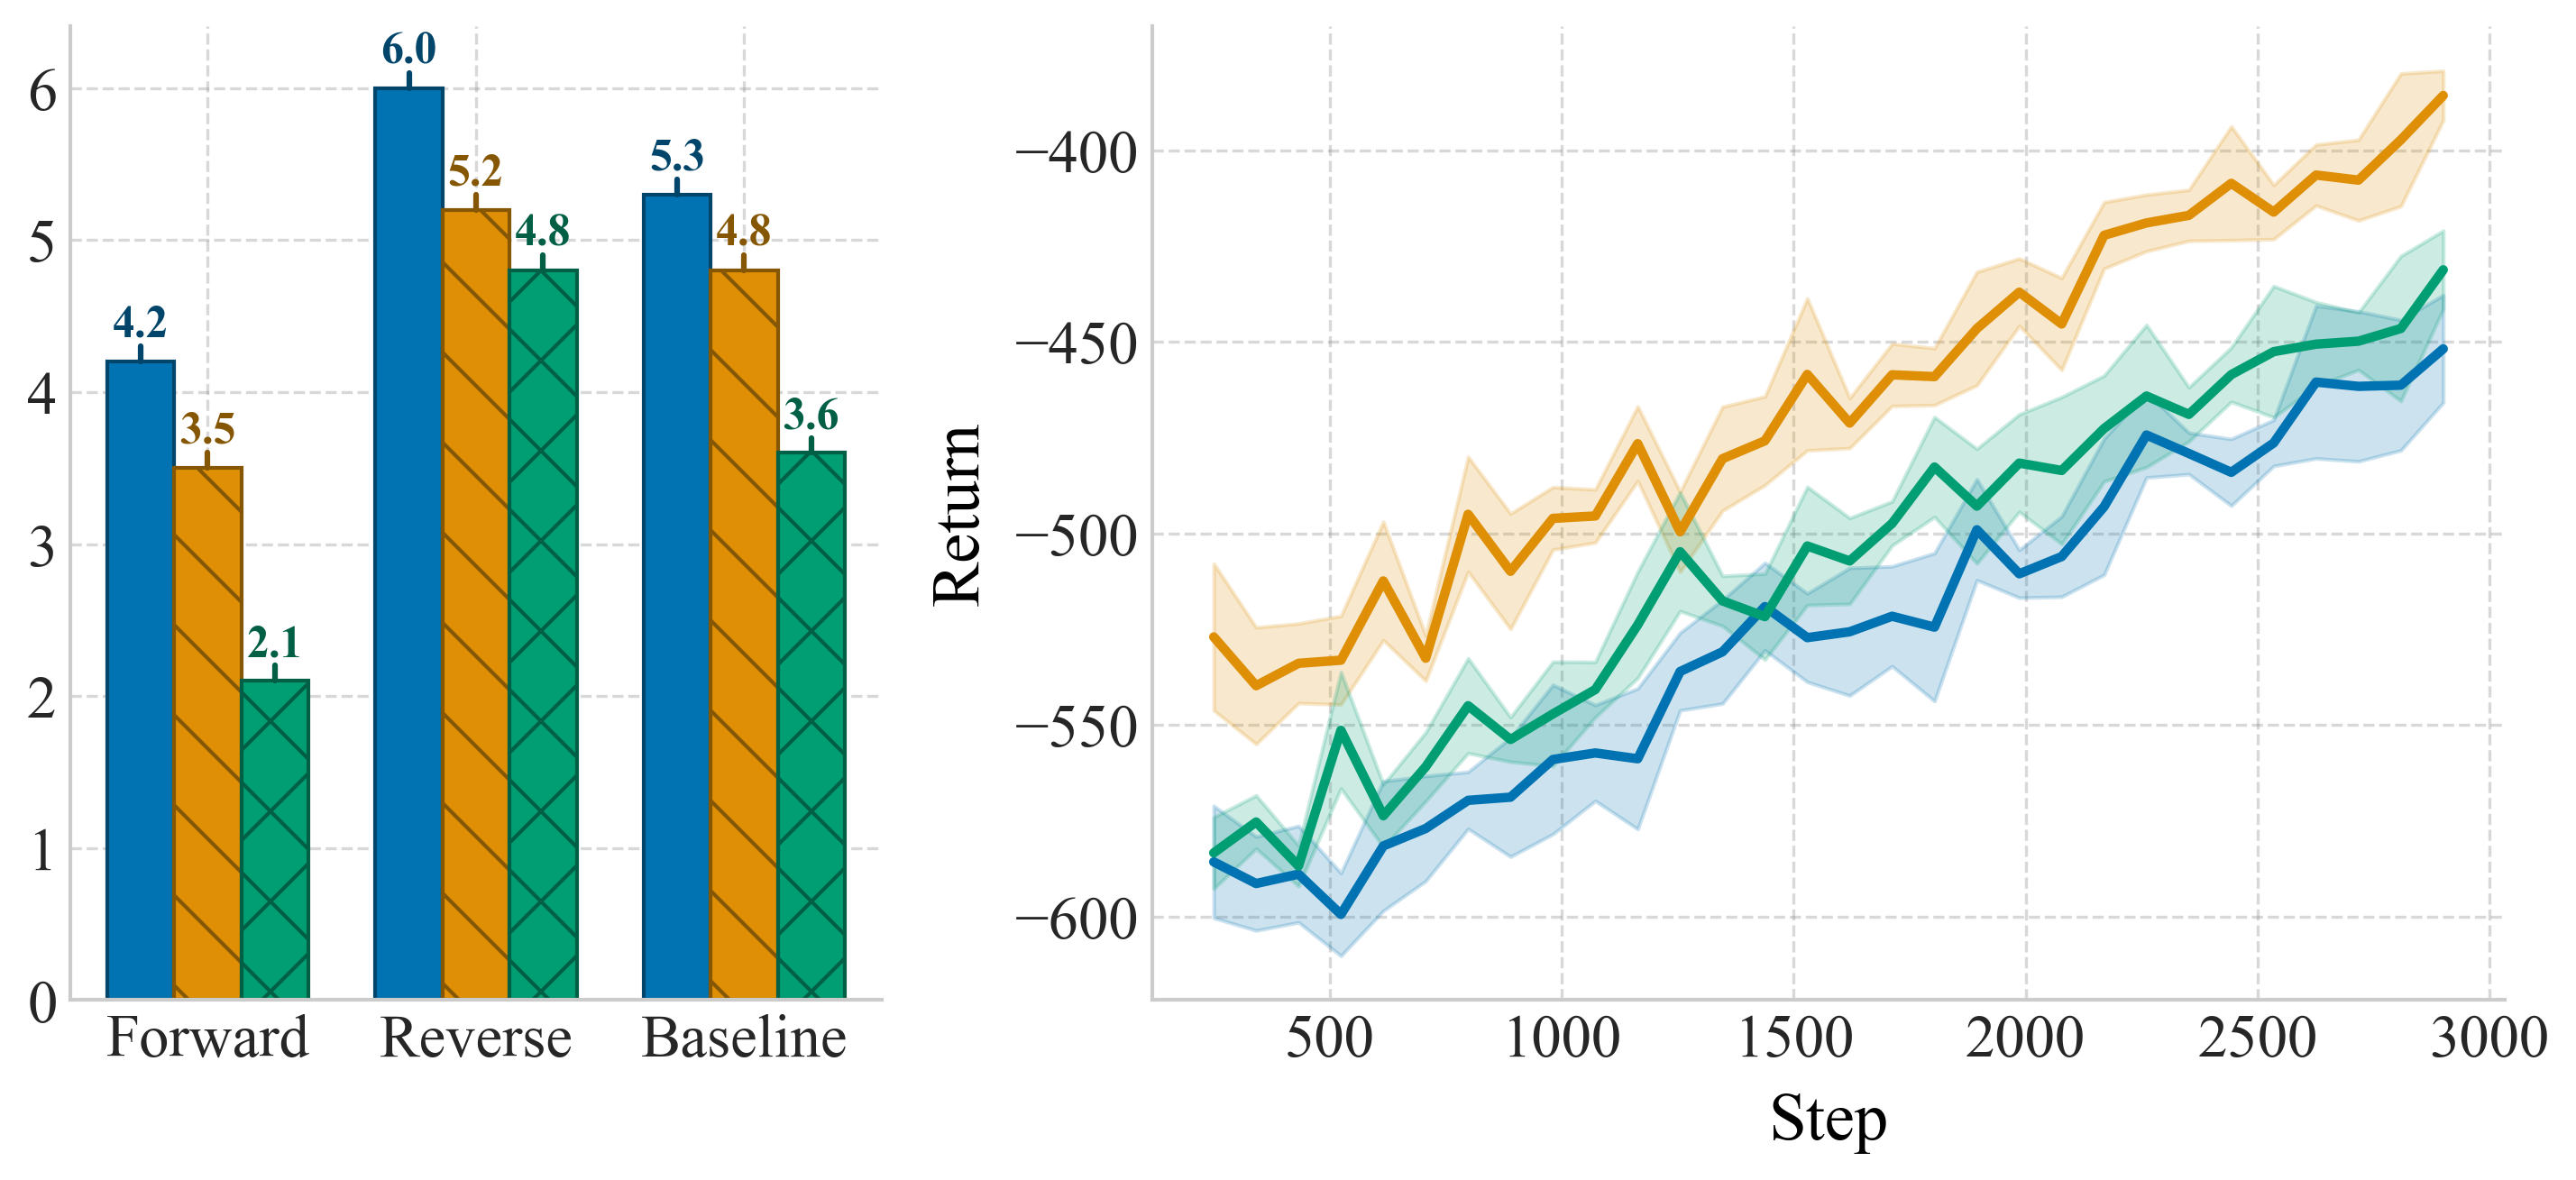

In [3]:
from swizz.layouts.blocks import Row

row_layout = Row([plot3, plot2], spacing=0.1)
fig = render_layout(row_layout, figsize=(10, 4))
plt.show()

Now, let's try to stack two plots vertically using `Col`

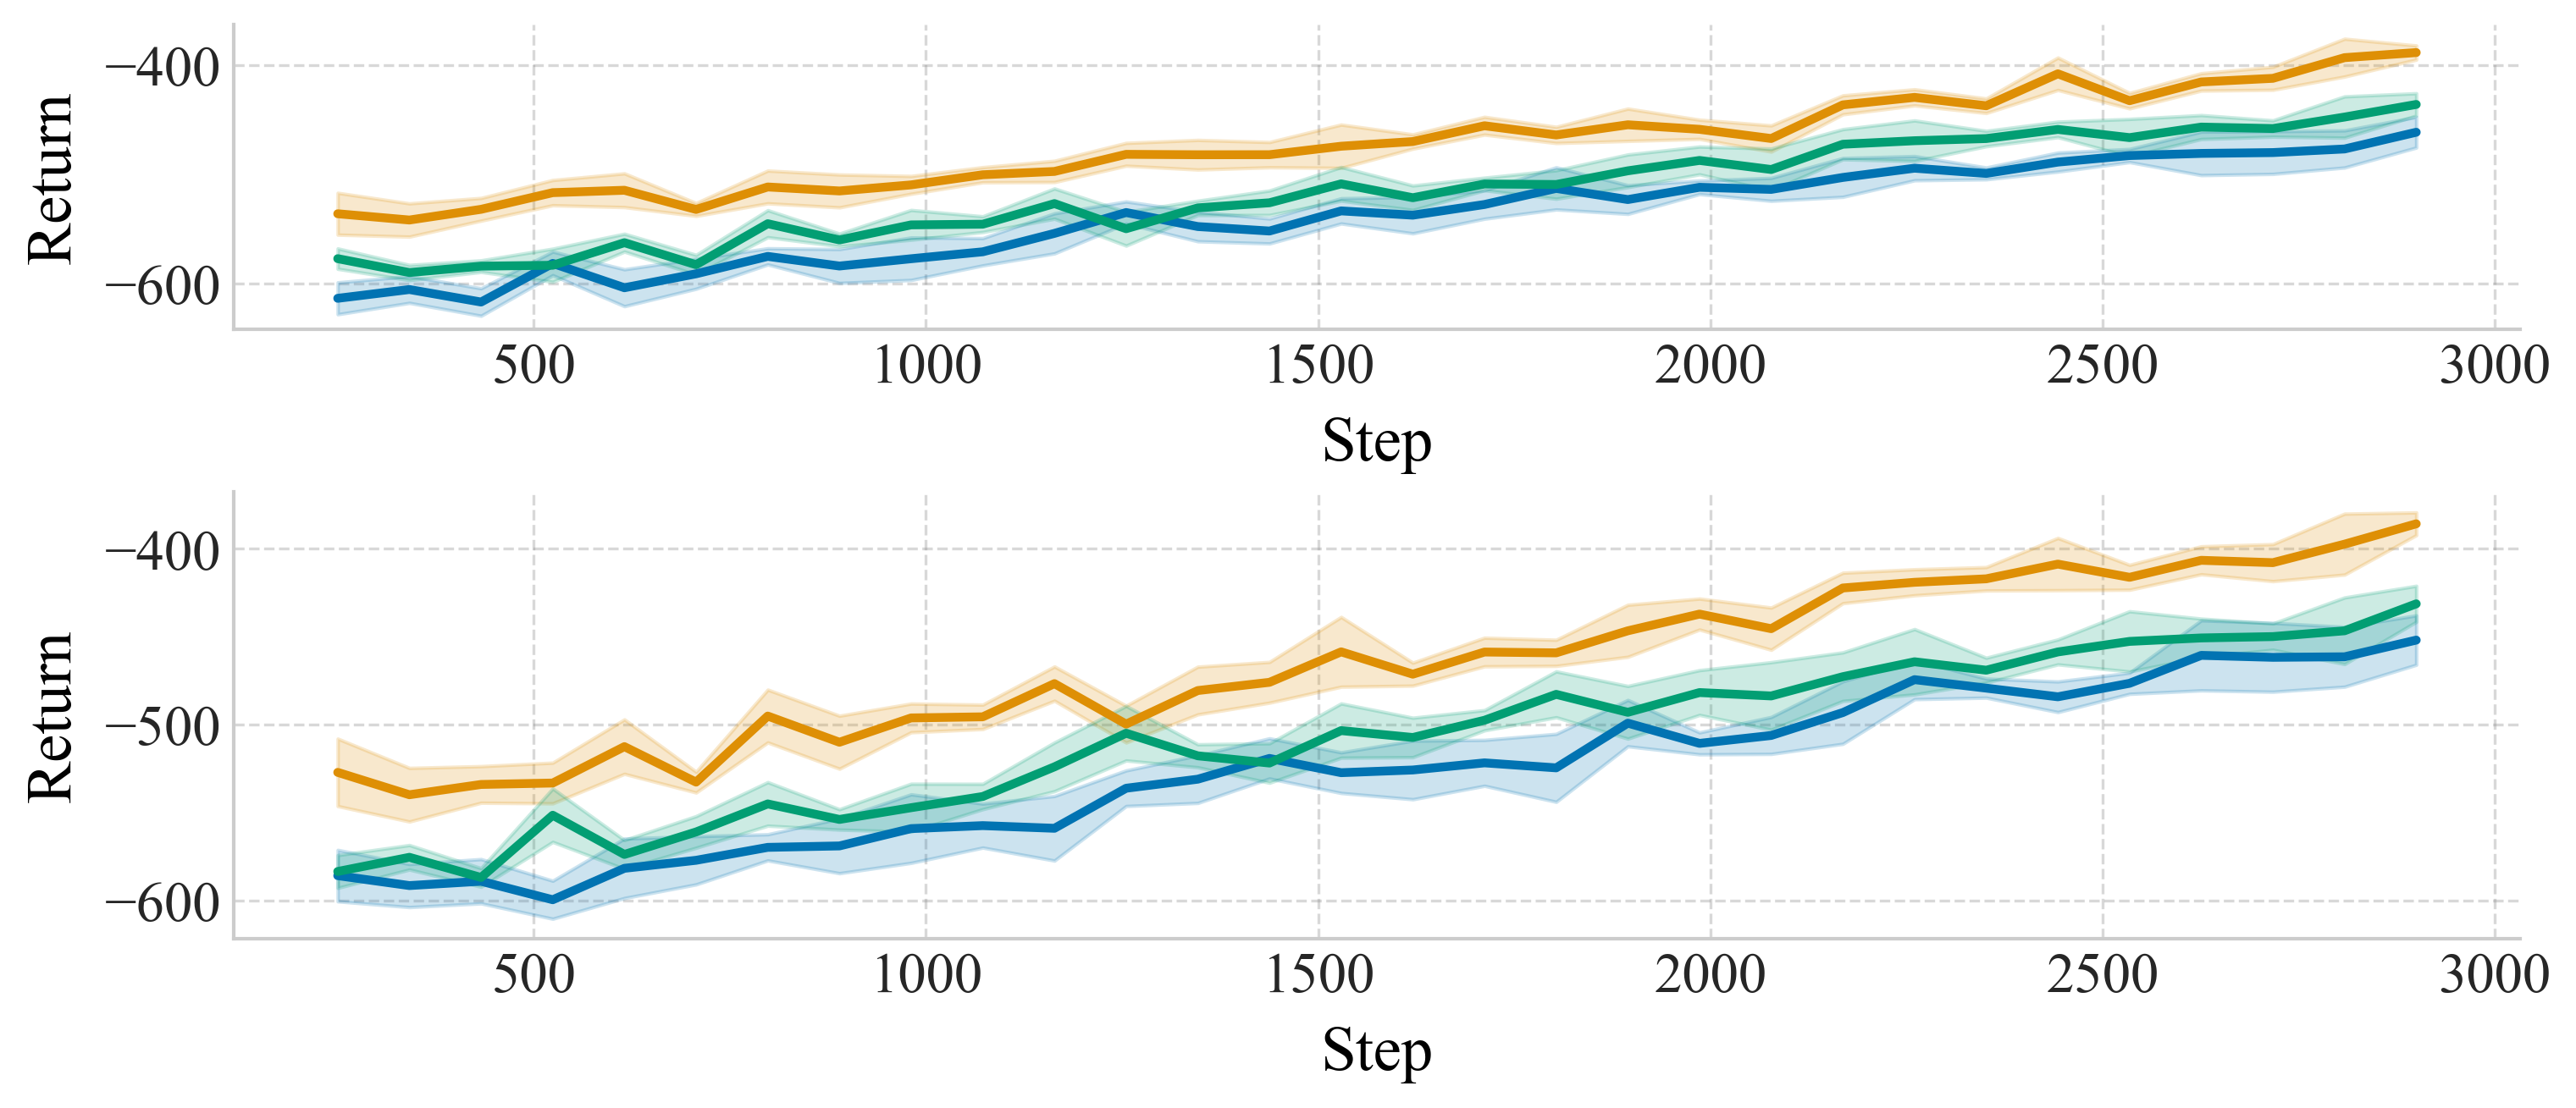

In [4]:
from swizz.layouts.blocks import Col

col_layout = Col([plot1, plot2], spacing=0.16)
fig = render_layout(col_layout, figsize=(10, 4))
plt.show()

### 🧷 Nesting Layouts
Layouts can be deeply nested, allowing you to compose complex figures from smaller, reusable parts. Just look at the example below:

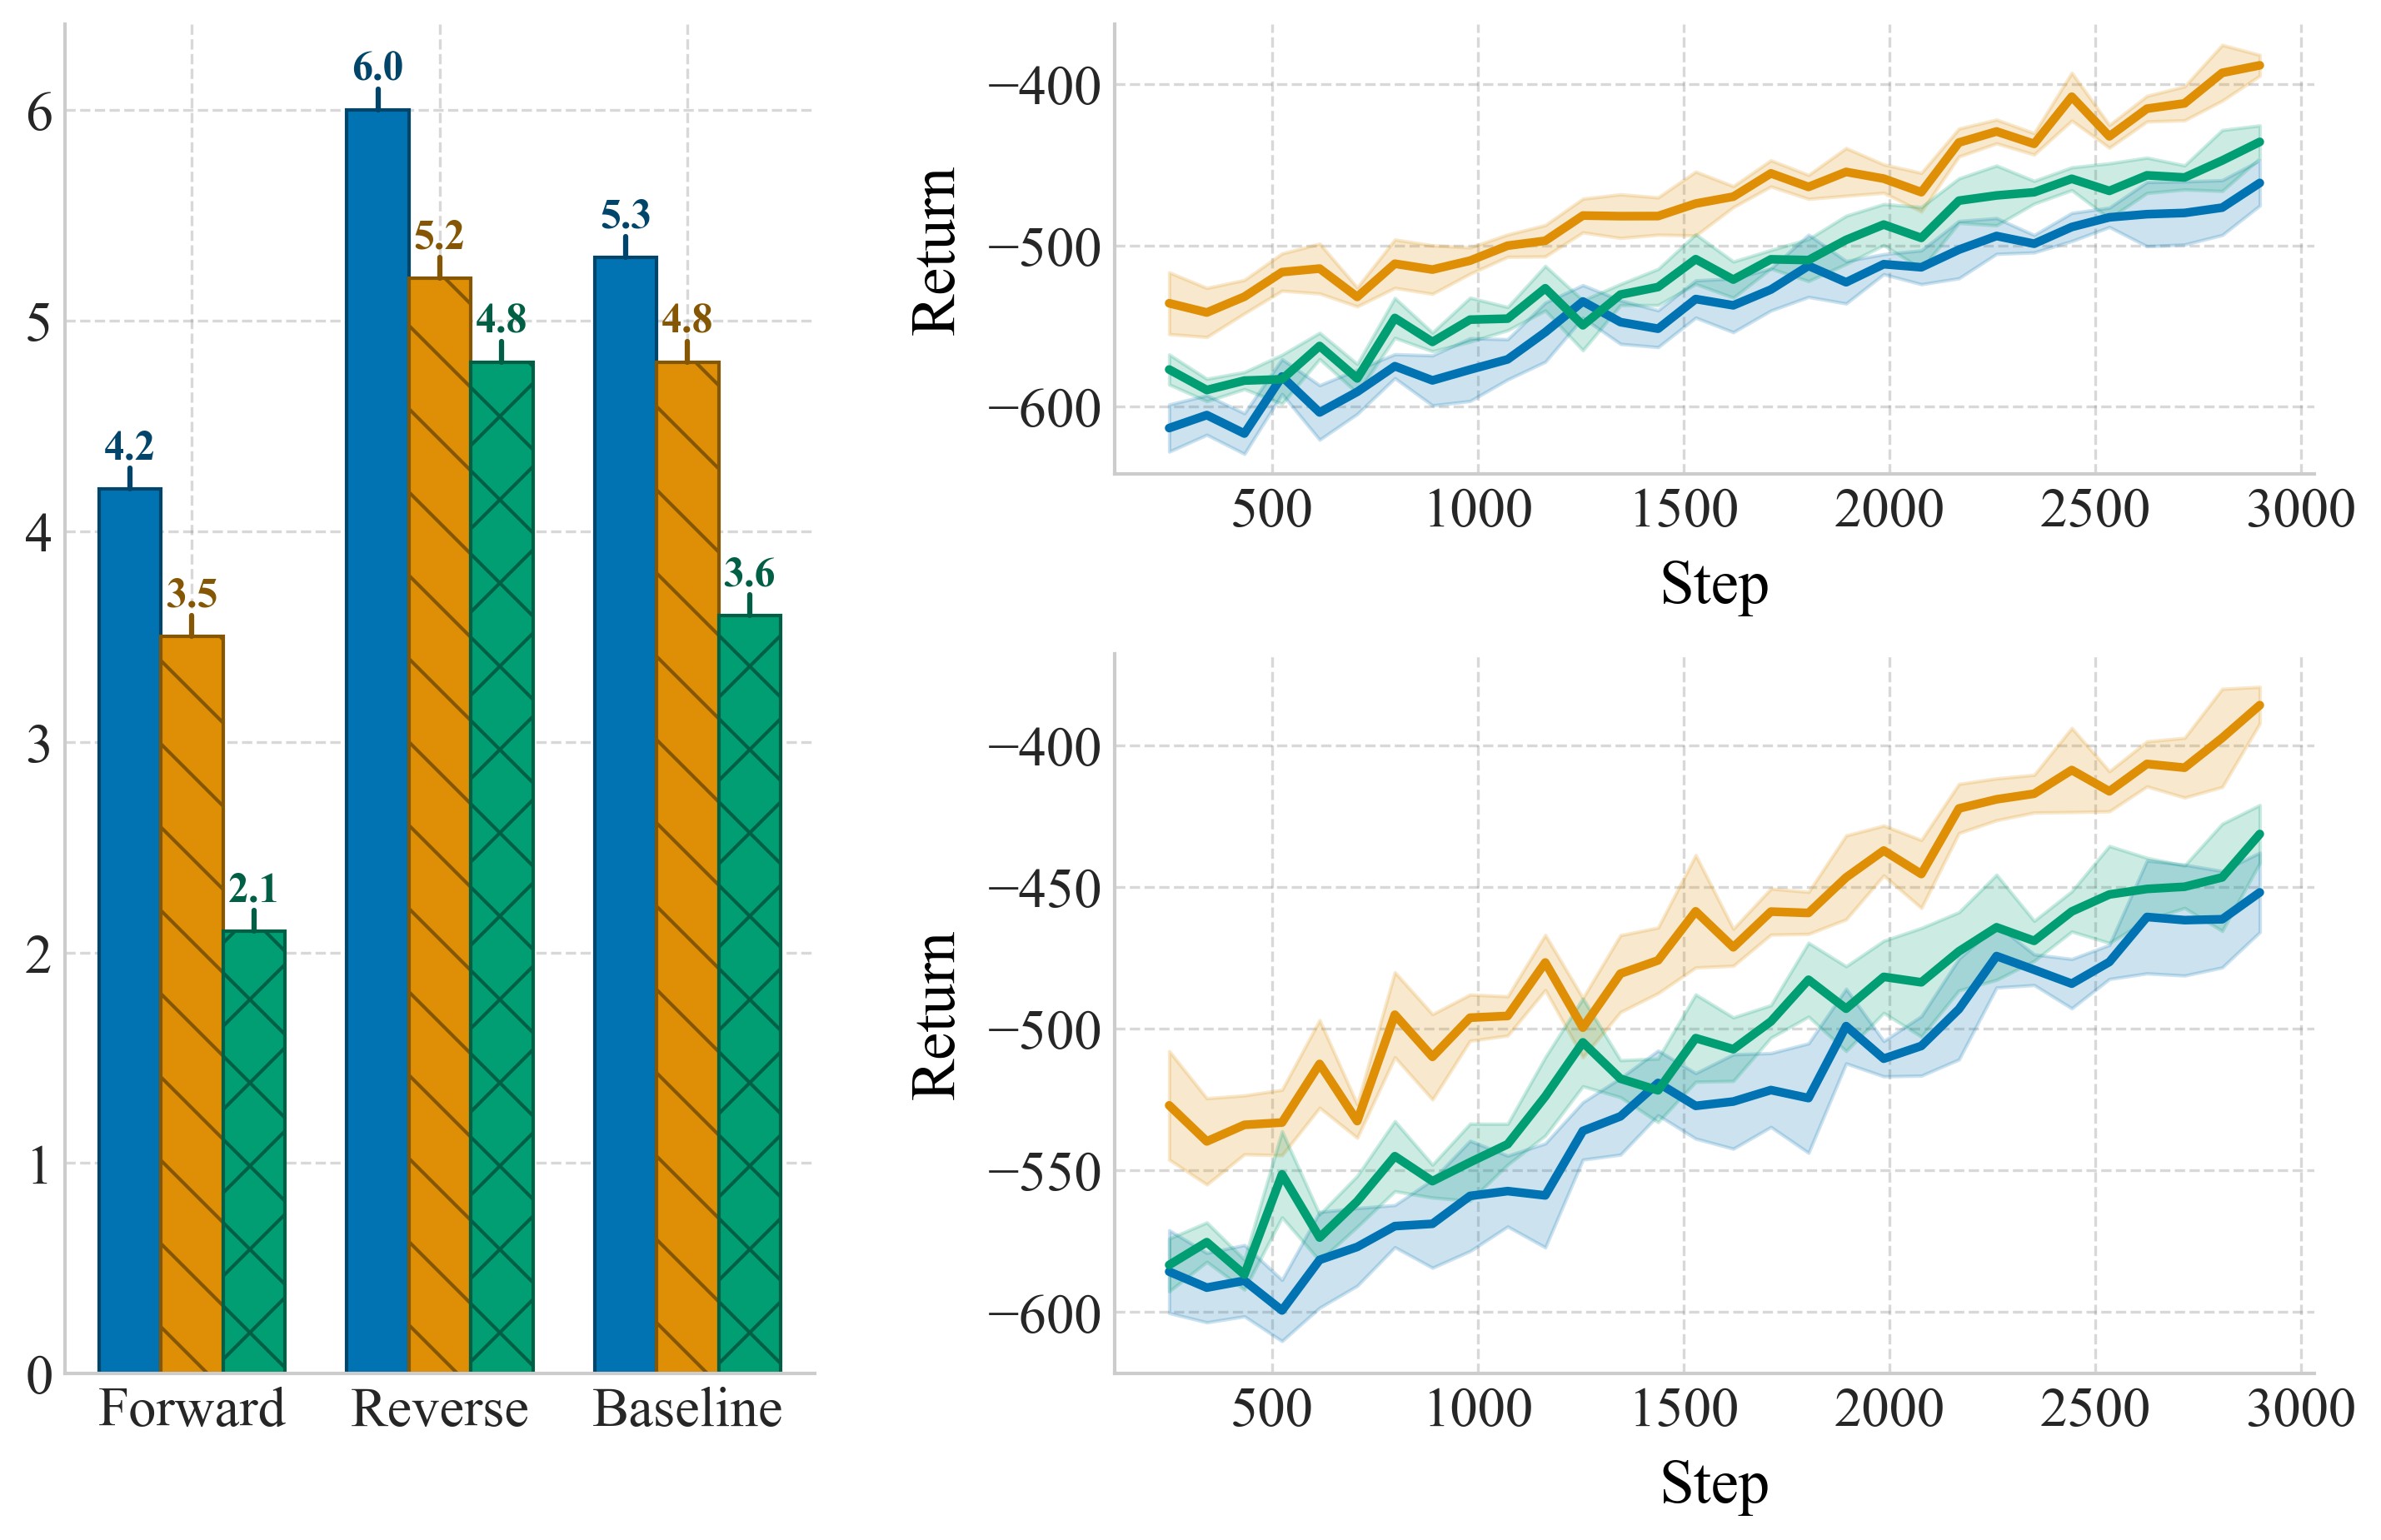

In [6]:
from swizz.layouts.blocks import LegendBlock, Label

nested_layout = Row([
    plot3, 
    Col([
        plot1, 
        plot2, 
    ], spacing=0.12)
], spacing=0.12)
fig = render_layout(nested_layout, figsize=(10, 6))
plt.show()

### 🏷️ Labels and Legends
#### Label
Use a `Label` block to annotate your figure — below a plot, above a column, or anywhere you need text.

You can control:
- Alignment ("left", "center", or "right")
- Font size and font family
- Optional fixed height to reserve space

#### LegendBlock
Instead of repeating legends inside every plot, use a `LegendBlock` to define a global legend.
- Define a shared list of labels
- `swizz` will gather matching handles from rendered plots
- Automatically ensures consistent color and line style

💡 *Note: For automatic legend collection, the plot labels must match exactly across plots.*

We will now add labels and legends to the nested plot that we created above.

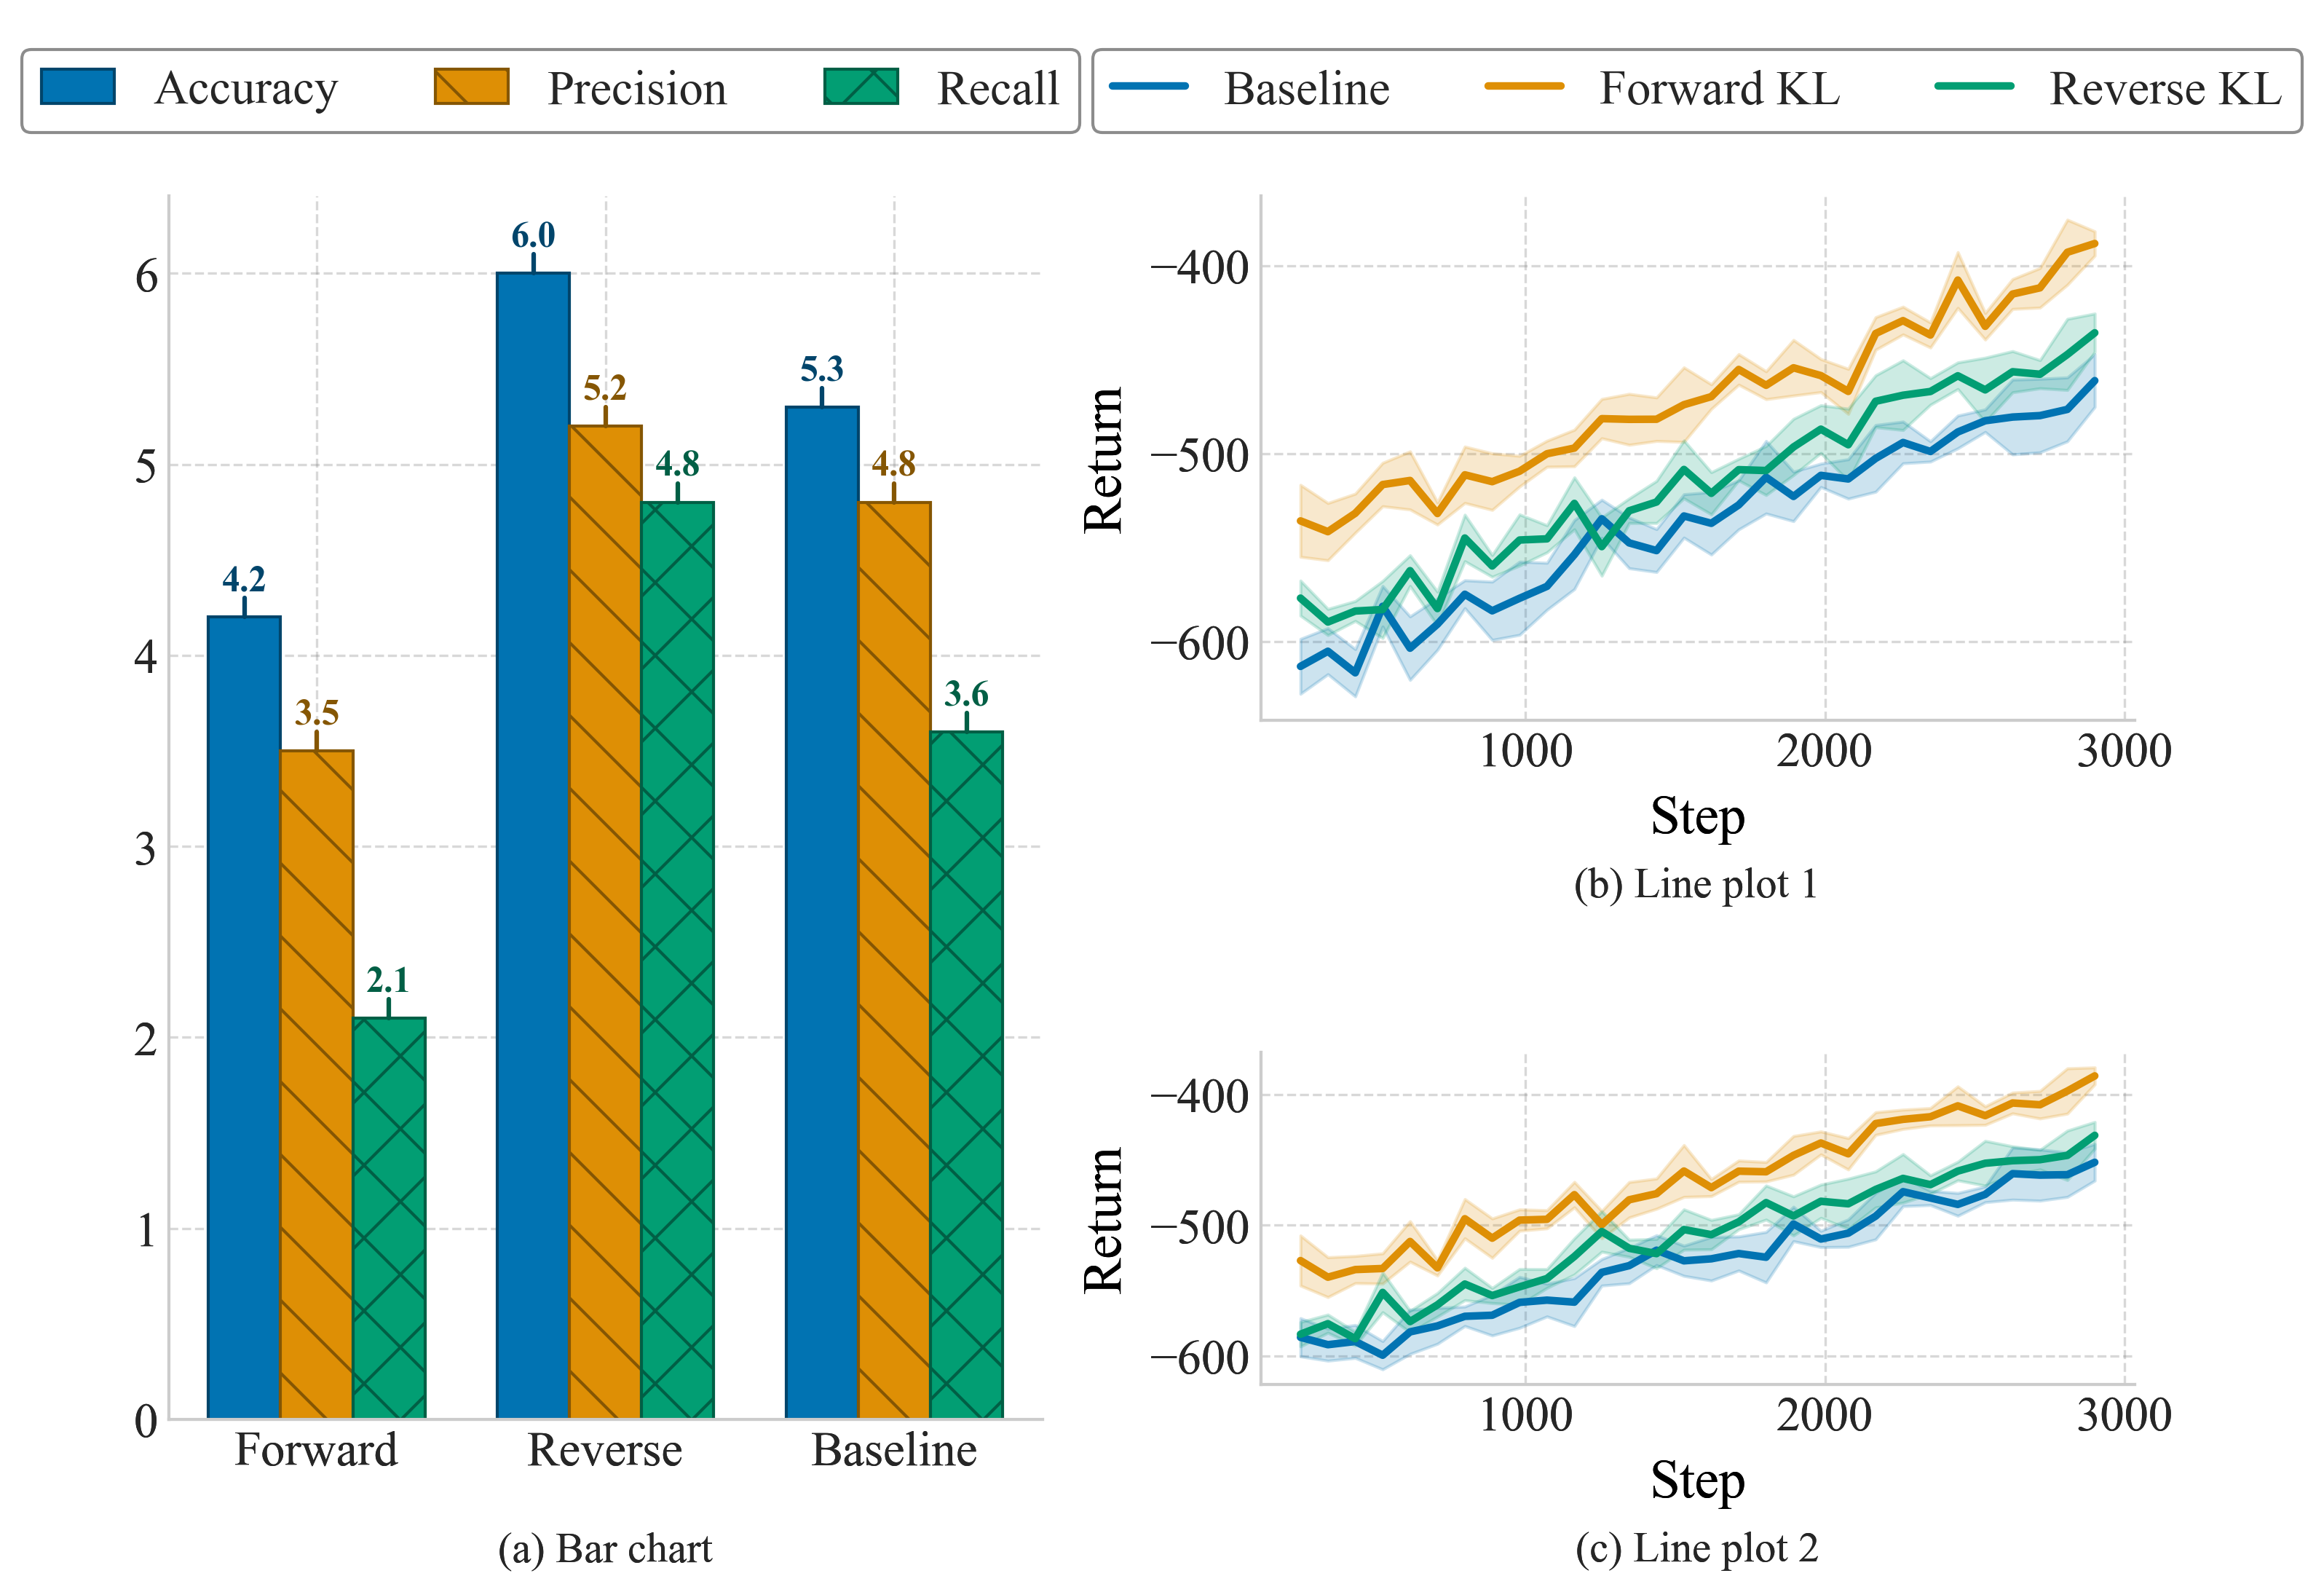

In [22]:
from swizz.layouts.blocks import LegendBlock, Label

nested_layout = Col([
    Row([
        LegendBlock(labels=["Accuracy", "Precision", "Recall"], ncol=3, fixed_width=0.35),
        LegendBlock(labels=["Forward KL", "Reverse KL", "Baseline"], ncol=3)
    ], fixed_height=0.08, spacing=0.15),
    Row([
        Col([
            plot3,
            Label("(a) Bar chart",  align="center", fixed_height=0.05), 
        ]),
        Col([
            plot1, 
            Label("(b) Line plot 1",  align="center", fixed_height=0.05), 
            plot2, 
            Label("(c) Line plot 2",  align="center", fixed_height=0.05)
        ], spacing=0.07)
    ], spacing=0.1), 
], spacing=0.02)

fig = render_layout(nested_layout, figsize=(10, 8))
plt.savefig("customlayout.pdf", bbox_inches='tight')
plt.show()

## 📣 Feedback & Contributions
We're just getting started with the `swizz.layouts` engine, and we’d love your input!
Our goal is to make it the most intuitive and expressive system for scientific figure composition.

Have an idea for a layout block?
Want support for figure titles, dynamic resizing, or alignment to external grids?

👉 Join the discussion on [GitHub Discussions](https://github.com/lars-quaedvlieg/swizz/discussions) and let us know what features you'd love to see.

If you're using `swizz` in your research, we’d also be thrilled to see your layouts! 🙌